# Assignment 3 - Ridge and Lasso Regression 

### We are going to predict baseball salaries from performance data.  

In [64]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


The task in this assignment is to build models of Baseball players (only fielding players, not pitchers) salaries based on statistics.  These are real data from MLB.  
Why is this an important task - if you are a player learn what gets you paid! 
I did a little bit of clean up of the csv as we read it in. 

In [65]:
df = pd.read_csv('Hitters.csv', index_col=0)
df.index.name = 'Player'
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

The first 7 variables are from the previous season.  The variables starting with a C are career statistics.  PutOuts, Assists, and Errors are also single season statistics.  Salary is their salary.  League, Division, and NewLeague reflect where they play. 

Always deal with problems.  Non-null count tells you how many entries you have that are not missing values.  `Salary` clearly shows missing values. 

In [66]:
#Lets preemptively get rid of garbage. 
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [67]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


1.  Encode and organize the data

There are 4 variables that are objects, i.e., string -  League, Division, and NewLeague.   You need to convert these into numeric variables, for example by using `get_dummies`.  

Take a moment to look at the values contained in each of these, and then make a strategy of how you want to encode them.  Keep in mind that each of them takes only two values, and you dont want to create variables that are redundant.  

NewLeague indicates the team the league is in for the new season.  Very few players change leagues, so there is not much information there.  You should remove it from the dataframe, and I assumed you did in the rest of this assignment.

The response variable is Salary.  The other variables are your predictors.  

In [68]:

dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary','League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X appending 
X = pd.concat([X_, dummies[['League_N', 'Division_W']]], axis=1)
df_final = pd.concat([X,df.Salary],axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    bool 
 1   League_N     263 non-null    bool 
 2   Division_E   263 non-null    bool 
 3   Division_W   263 non-null    bool 
 4   NewLeague_A  263 non-null    bool 
 5   NewLeague_N  263 non-null    bool 
dtypes: bool(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby           False      True       False        True        False   
-Alvin Davis           True     False       False        True         True   
-Andre Dawson         False      True        True       False        False   
-Andres Galarraga     False      True        True       False        False   
-Alfredo Griffin       True     False       False     

2.  Its useful to do some exploratory data analysis.  
    First, visualize just the single season statistics. The first 7 columns in the dataframe from contain the single season statistics.  A pairplot would be a useful idea. You should immediately see that some of these variables are highly correlated. 

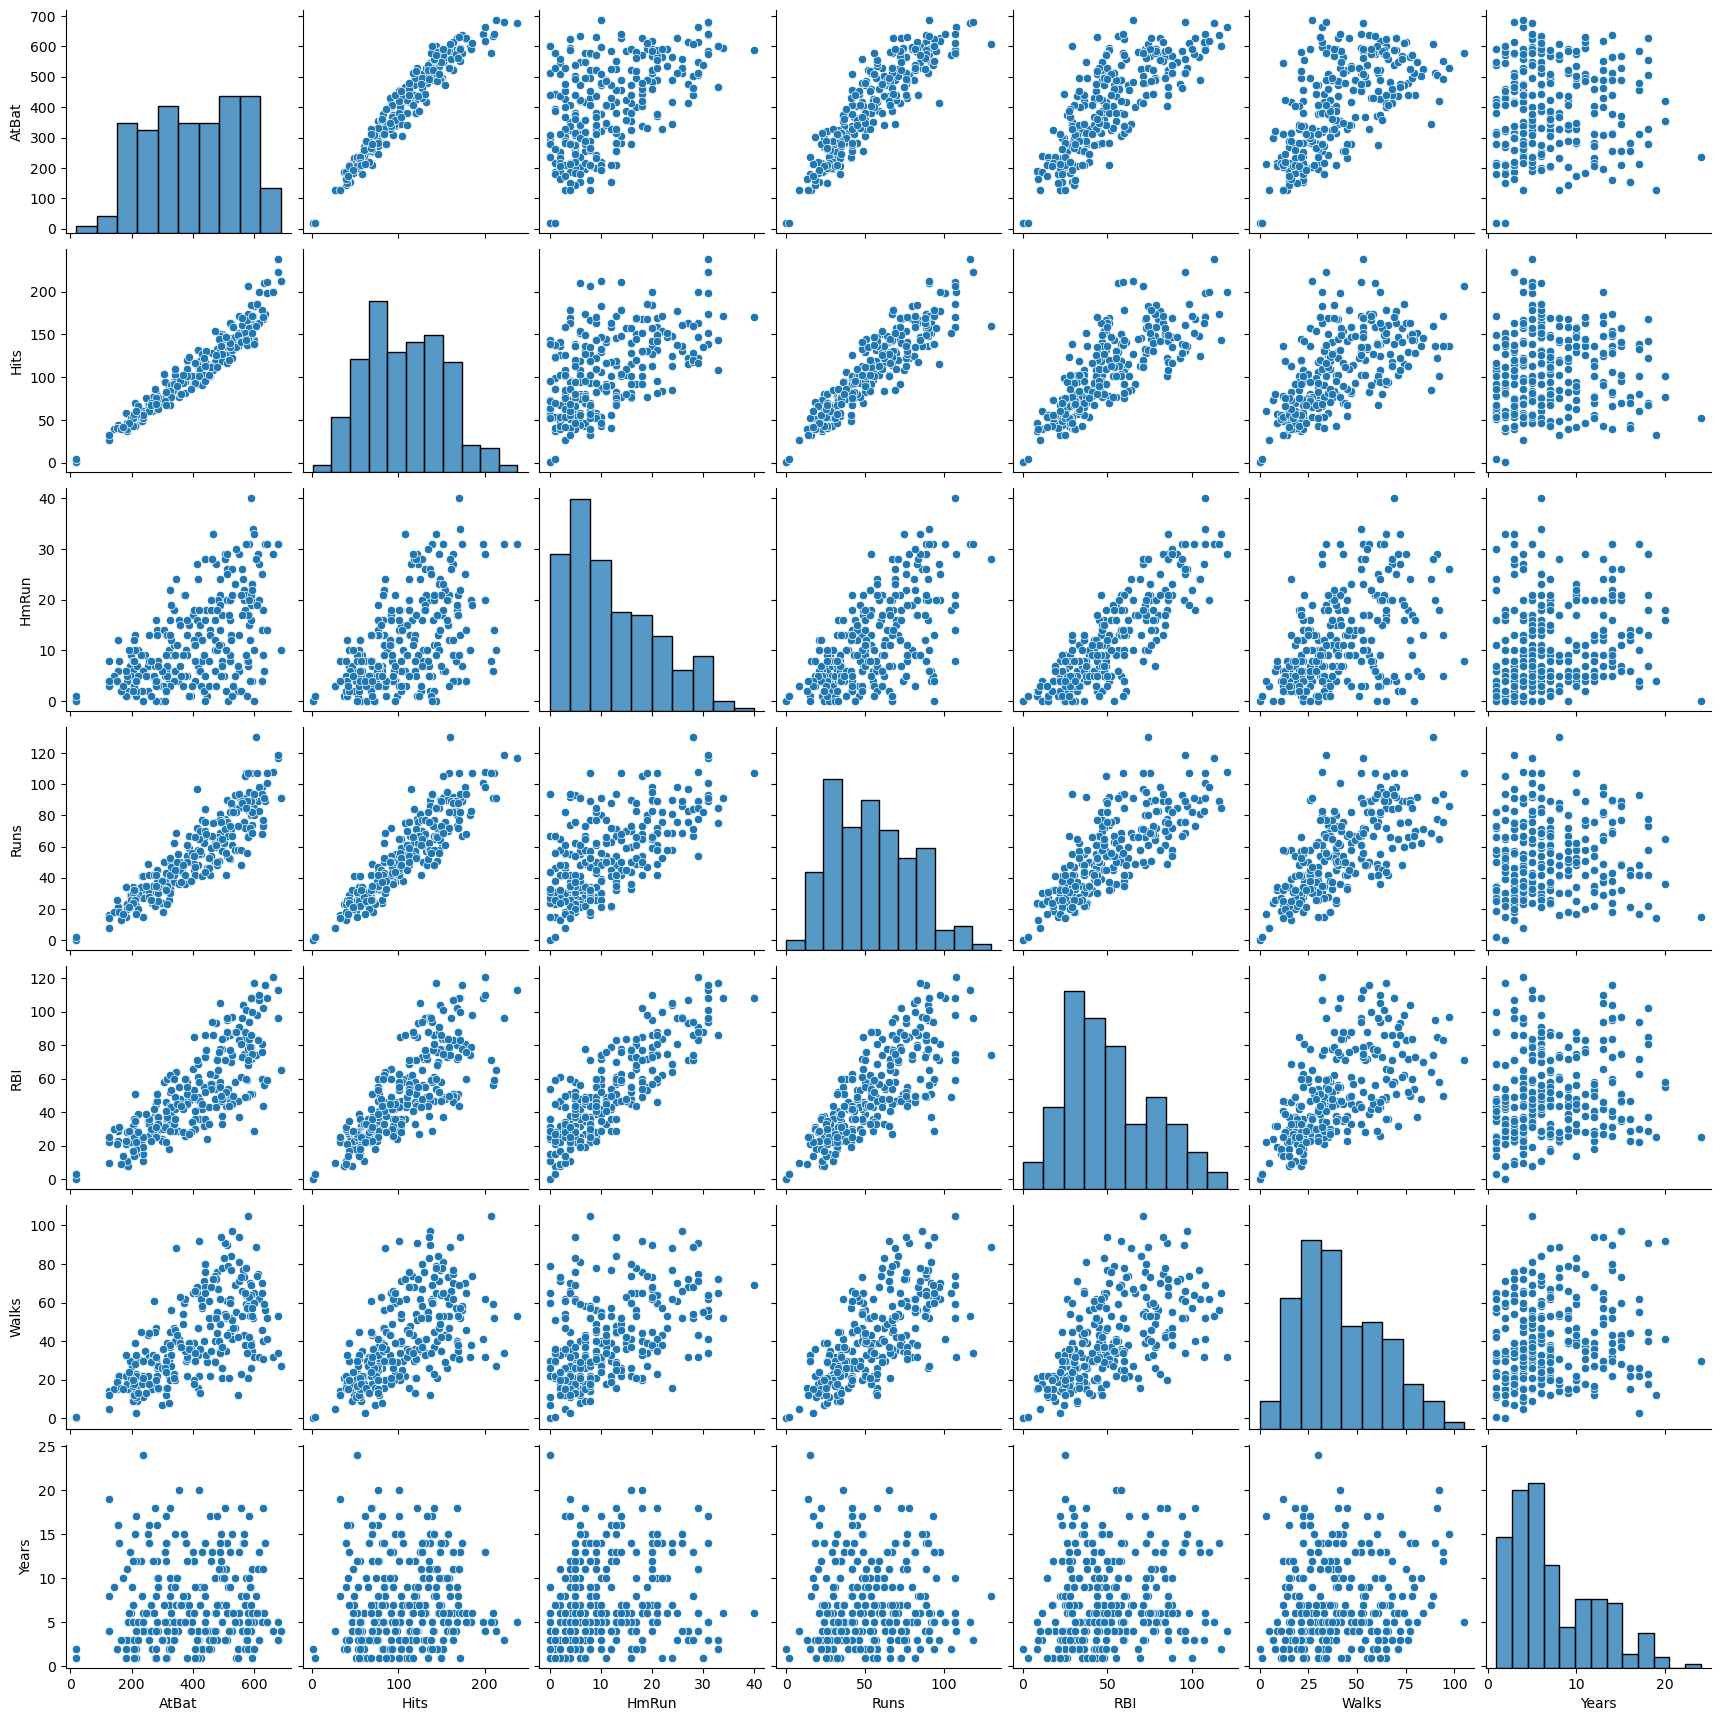

In [69]:
#I always like to get a variable with all the column names 
df_columns = df_final.columns
X_columns = X.columns
sns.pairplot(df_final.iloc[:,0:7])

Make a heatmap showing the correlations between all the variables.  This will not work unless you have converted it all into dummy variables 

<Axes: >

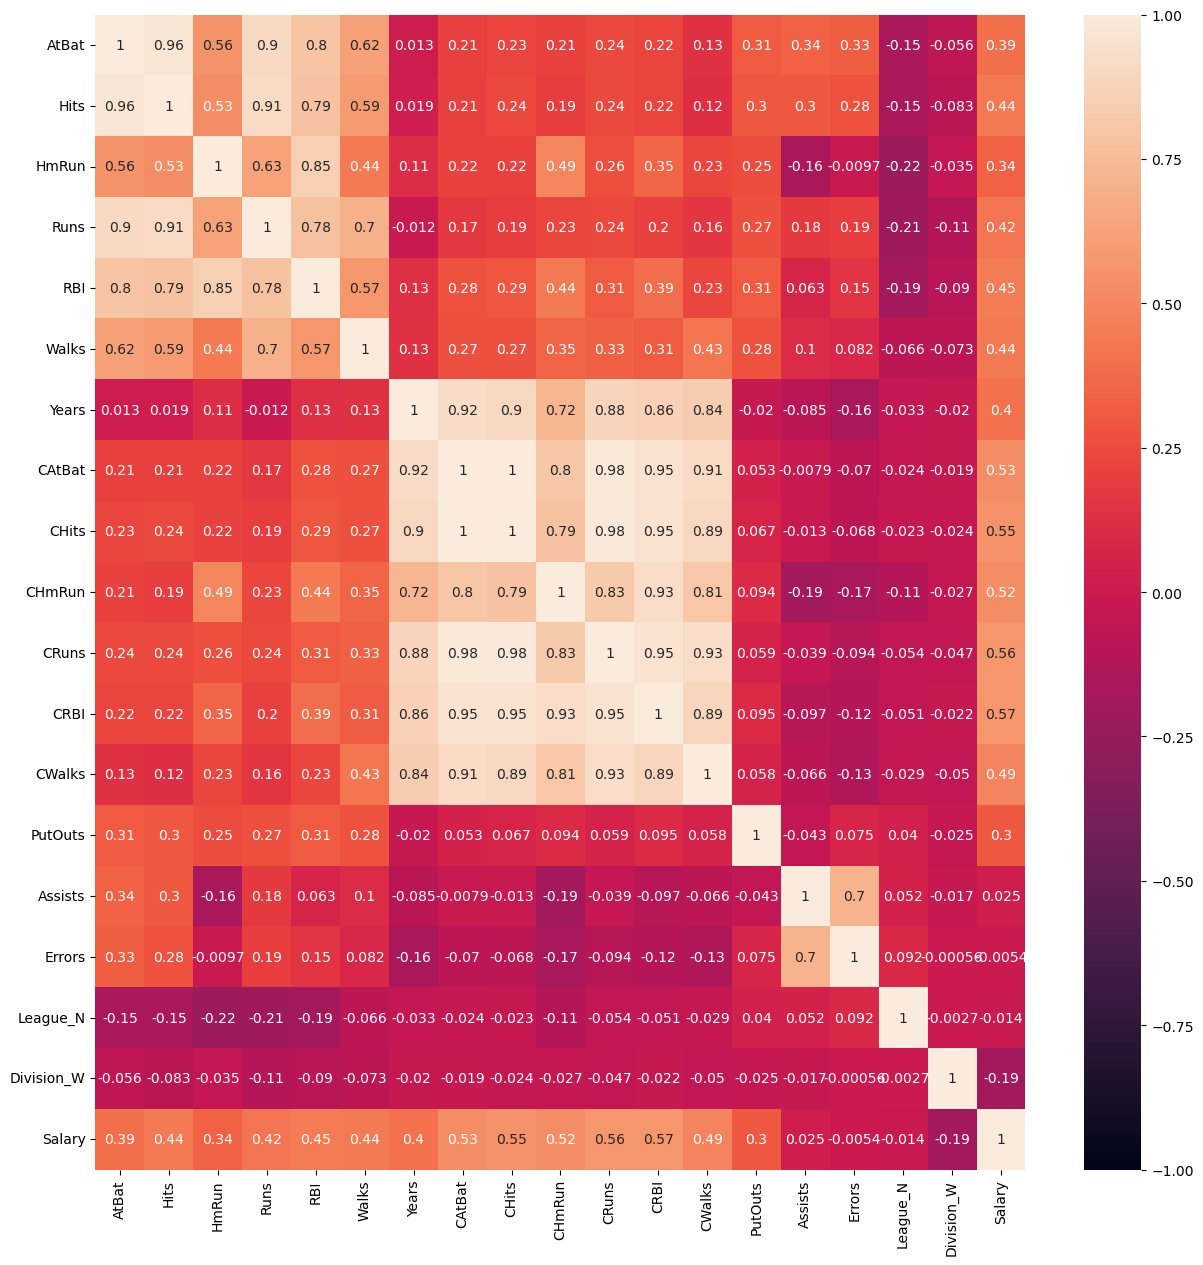

In [70]:
#I had to do this before making the heatmap to see everything.  
plt.figure(figsize = (15,15))
sns.heatmap(df_final.corr(), vmin=-1, vmax=1, annot=True)

In [ ]:
from sklearn.decomposition import PCA 
pc = PCA()


Write down your impression of the data in the box below   What variables are highly correlated?  Are the single season statistics and career statistics highly correlated? What are some candidate variables that could explain salary? 

3.  Separate the data into test (25%) and training sets.  Also separate the response variable (salary) into a separate variable y, and the predictors into a separate variable X.  Use StandardScaler to scale the predictors.   Whether you choose the scale the response variable is somewhat arbitrary.  If you dont, you will get a model that predicts actual salaries and has an intercept.  For this exercise lets do it that way. 

- Split the data into training and test sets 

In [71]:
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 22,shuffle=True)

- Build a standard scaler model from the training set and apply to training and test sets.  

In [72]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test) # notice that the test data is not being fit

4.  Fit a model using OLS (`LinearRegression`).  Quantify how it fits the data in the test set by computing $r^2$.  Make a scatter plot showing the predicted salaries against the actual salaries in the test set. Make a bar plot showing the regression coefficients (`.coef_`) on each predictor. In the empty markdown box, write down how you would describe the model. 

## Multiple Linear Regression 

0.46046709773994876


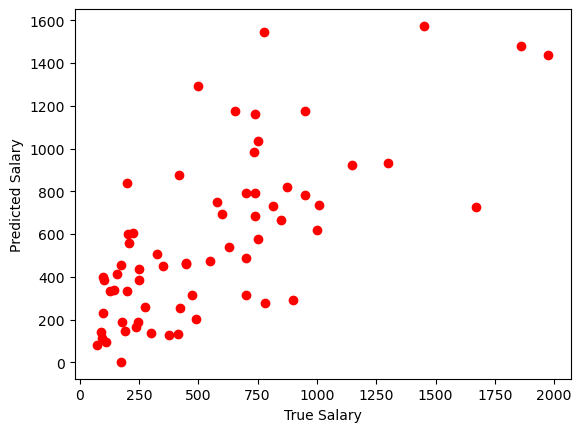

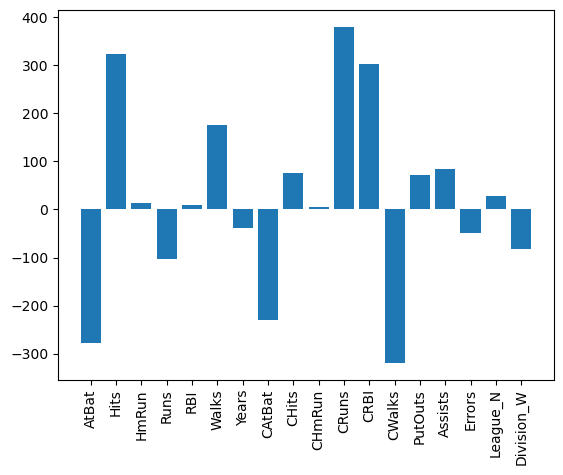

In [73]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)
r2_ols = reg.score(X_test,y_test)
print(r2_ols)
plt.figure()
plt.plot(y_test,y_pred,'ro')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.show()
plt.figure()
plt.bar(X.columns,reg.coef_)
plt.xticks(rotation= "vertical")
plt.show()

Discuss your results here.  What do you think are the most important predictors.  What does it mean if the $\beta$ is positive versus negative.  

5.  Fit a model using Ridge Regression with cross validation.
* The `RidgeCV()` function has an $\alpha$ argument that is $\lambda$ from the lecture notes used to tune the model.
* `RidgeCV()` requires a range of value of $\alpha$ to be specified. The selected $\alpha$ will make use of cross-validation.  
* $\alpha$  = 0 is equivalent to the Least Squares solution, but it is not recommended to you actually set $\alpha$ = 0 so avoid that.  
* We expect the coefficient estimates to be much smaller, in terms of $L_2$ norm, when a large value of $\alpha$ is used,
* A very large $\alpha$ has tiny coefficients and and the model is dominated by the intercept. 
* By default `RidgeCV()` performs generalized cross-validation(essentially Leave one-out CV),
* This can be changed using the argument `cv`.

        alphas = 10**np.linspace(5,-5,20)
        ridgecv = RidgeCV(alphas = alphas,cv = 5) # 5-fold cross validation
* the best value of alpha (over the range tested) is in `ridgecv.alpha_`
* Evaluate the model by predicting the test data  


In [74]:
alphas = 10**np.linspace(5,-5,20)
ridgecv = RidgeCV(alphas = alphas,cv = 5) # 5-fold cross validation
ridgecv.fit(X_train, y_train) #fit model 
bestalpha = ridgecv.alpha_ #get the best value of alpha 
print(bestalpha) #
r2_ridge = ridgecv.score(X_test, y_test)
y_pred = reg.predict(X_test)
print(r2_ridge)

6.158482110660267
0.4793279204930324


Make a scatter plot of the predicted salaries versus the actual salaries. Make a bar graph of the weights on the coefficients. 


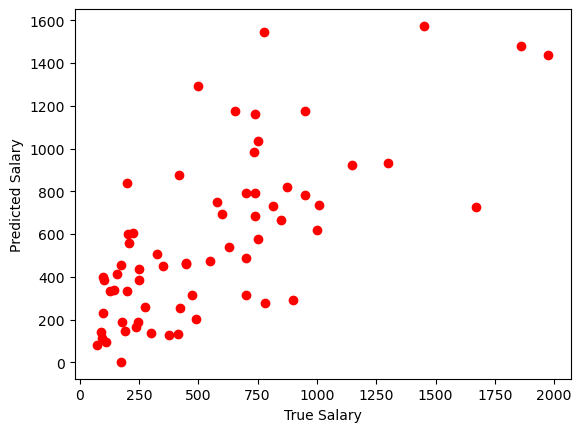

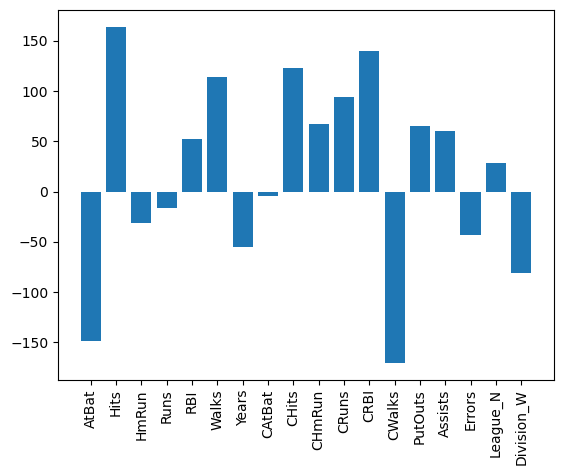

In [75]:
plt.figure()
plt.plot(y_test,y_pred,'ro')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.show()
plt.figure()
plt.bar(X.columns,ridgecv.coef_)
plt.xticks(rotation= "vertical")
plt.show()

5.  Fit a model using LASSO Regression with cross validation. Use `LassoCV` with the same range of alpha values.  (This is not strictly required.  Typically you should test more small values of alpha)

In [76]:
lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lassocv.fit(X_train, y_train)
r2_lasso = lassocv.score(X_test,y_test)
y_pred = lassocv.predict(X_test)
print(r2_lasso)
lassocv.alpha_

0.5033821714600729


np.float64(6.158482110660267)

Make a scatter plot of the predicted and actual values of salary.  Make a bar graph of the Lasso coefficients (some of them are zero)

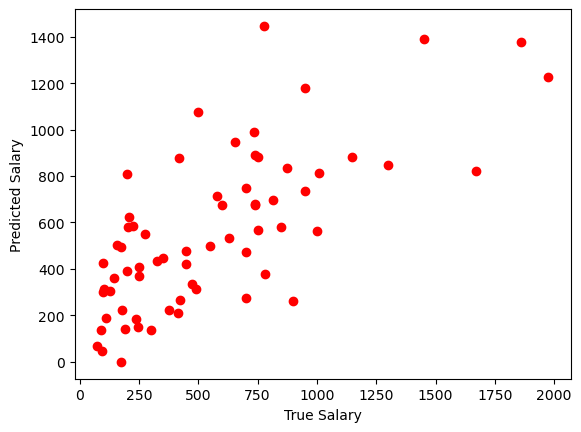

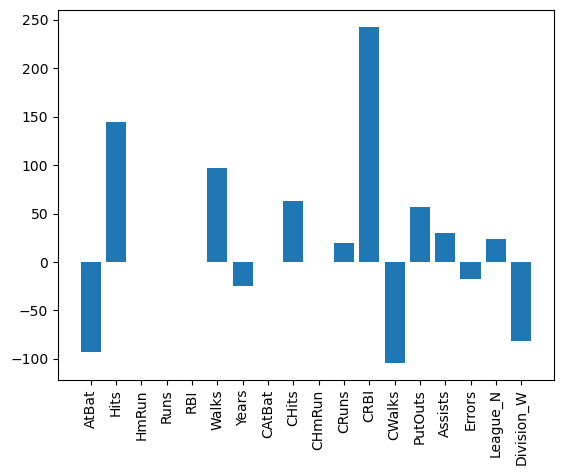

In [77]:
plt.figure()
plt.plot(y_test,y_pred,'ro')
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.show()
plt.figure()
plt.bar(X.columns,lassocv.coef_)
plt.xticks(rotation= "vertical")
plt.show()

6. I would like you to summarizethe results of this analysis, focusing on comparing Ridge and Lasso. 
    - How did they perform in prediction? is there a big difference?
    - What are the similarities in the pattern of coefficients selected? 
    - What are the differences? 
    - Does the correlation between the predictors have an effect on the two models?
    - Are there any surprising results in either model? 
    - Which model is easier to talk about?  
    - Is East Coast bias real? 